# Visualize Labeled ARCS Data

In [664]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import json

## Choose five frames

In [666]:
bin_path_0 = '..\\data\\velodyne_points\\000002.bin'
points_0 = np.fromfile(bin_path_0, dtype=np.float32).reshape(-1, 4)
labels_0 = '..\\data\\labels\\000002.txt'

bin_path_1 = '..\\data\\velodyne_points\\000005.bin'
points_1 = np.fromfile(bin_path_1, dtype=np.float32).reshape(-1, 4)
labels_1 = '..\\data\\labels\\000005.txt'

bin_path_2 = '..\\data\\velodyne_points\\000005.bin'
points_2 = np.fromfile(bin_path_2, dtype=np.float32).reshape(-1, 4)
labels_2 = '..\\data\\normalized_labels\\000005.txt'

bin_path_3 = '..\\data\\velodyne_points\\000052.bin'
points_3 = np.fromfile(bin_path_3, dtype=np.float32).reshape(-1, 4)
labels_3 = '..\\data\\normalized_labels\\000052.txt'

bin_path_4 = '..\\data\\velodyne_points\\000202.bin'
points_4 = np.fromfile(bin_path_4, dtype=np.float32).reshape(-1, 4)
labels_4 = '..\\data\\normalized_labels\\000202.txt'

## Visualization functions

Interesting. So right off the bat, my function is plotting the bounding boxes in a different spot that the point clouds (I'm working with lidar). I think this is because of how the previous person converted the data from the labeler. I'm not sure if I should change all the labels so they are formatted better, but first, I want to see if I can just visualize them correctly. 

In [669]:
# Function to plot the bounding box
def plot_bbox(ax, bbox):
    # Assuming bbox is in the format [x, y, z, dx, dy, dz, yaw] and centered at (x, y, z)
    
    dz, dy, dx, x, z, y, yaw = bbox
    
    corners = np.array([
        [x - dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y + dy/2, z + dz/2],
        [x - dx/2, y + dy/2, z + dz/2]
    ])
    

    # Rotate corners around the Z-axis (around their centers)
    rotation_matrix = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw),  np.cos(yaw), 0],
        [0,            0,           1]
    ])

    # # Adjust the corners to be about the origin for rotation, then add the [x, y, z] back after rotation
    corners = corners - np.array([x, y, z])
    corners = np.dot(corners, rotation_matrix.T)
    corners += np.array([x, y, z])
    
    # Rotate the entire bounding box 90 degrees (pi/2 radians) around the origin
    rotation_matrix = np.array([
        [np.cos(-np.pi / 2), -np.sin(-np.pi / 2), 0],
        [np.sin(-np.pi / 2),  np.cos(-np.pi / 2), 0],
        [0,                    0,                 1]
    ])
    
    # Apply the rotation to the corners
    corners = np.dot(corners, rotation_matrix.T)
    
    # Define the edges of the bounding box
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]
    # Plot the edges
    for edge in edges:
        ax.plot3D(*zip(corners[edge[0]], corners[edge[1]]), color='r', linewidth=2)

In [670]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.'''
    
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the 'box size'.
    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

In [671]:
def read_kitti_labels(label_path):
    bboxes = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            bbox = [float(value) for value in parts[8:15]]  # Extract the bounding box dimensions and location
            bboxes.append(bbox)
    return np.array(bboxes)

In [672]:
print(read_kitti_labels(labels_0))

[[  2.02   2.76   5.22 -31.18  -1.91  -0.73   0.51]
 [  2.02   2.71   4.95 -30.38  -0.21  26.84   5.2 ]
 [  2.13   2.48   5.36 -28.66  -0.11  29.51   5.21]]


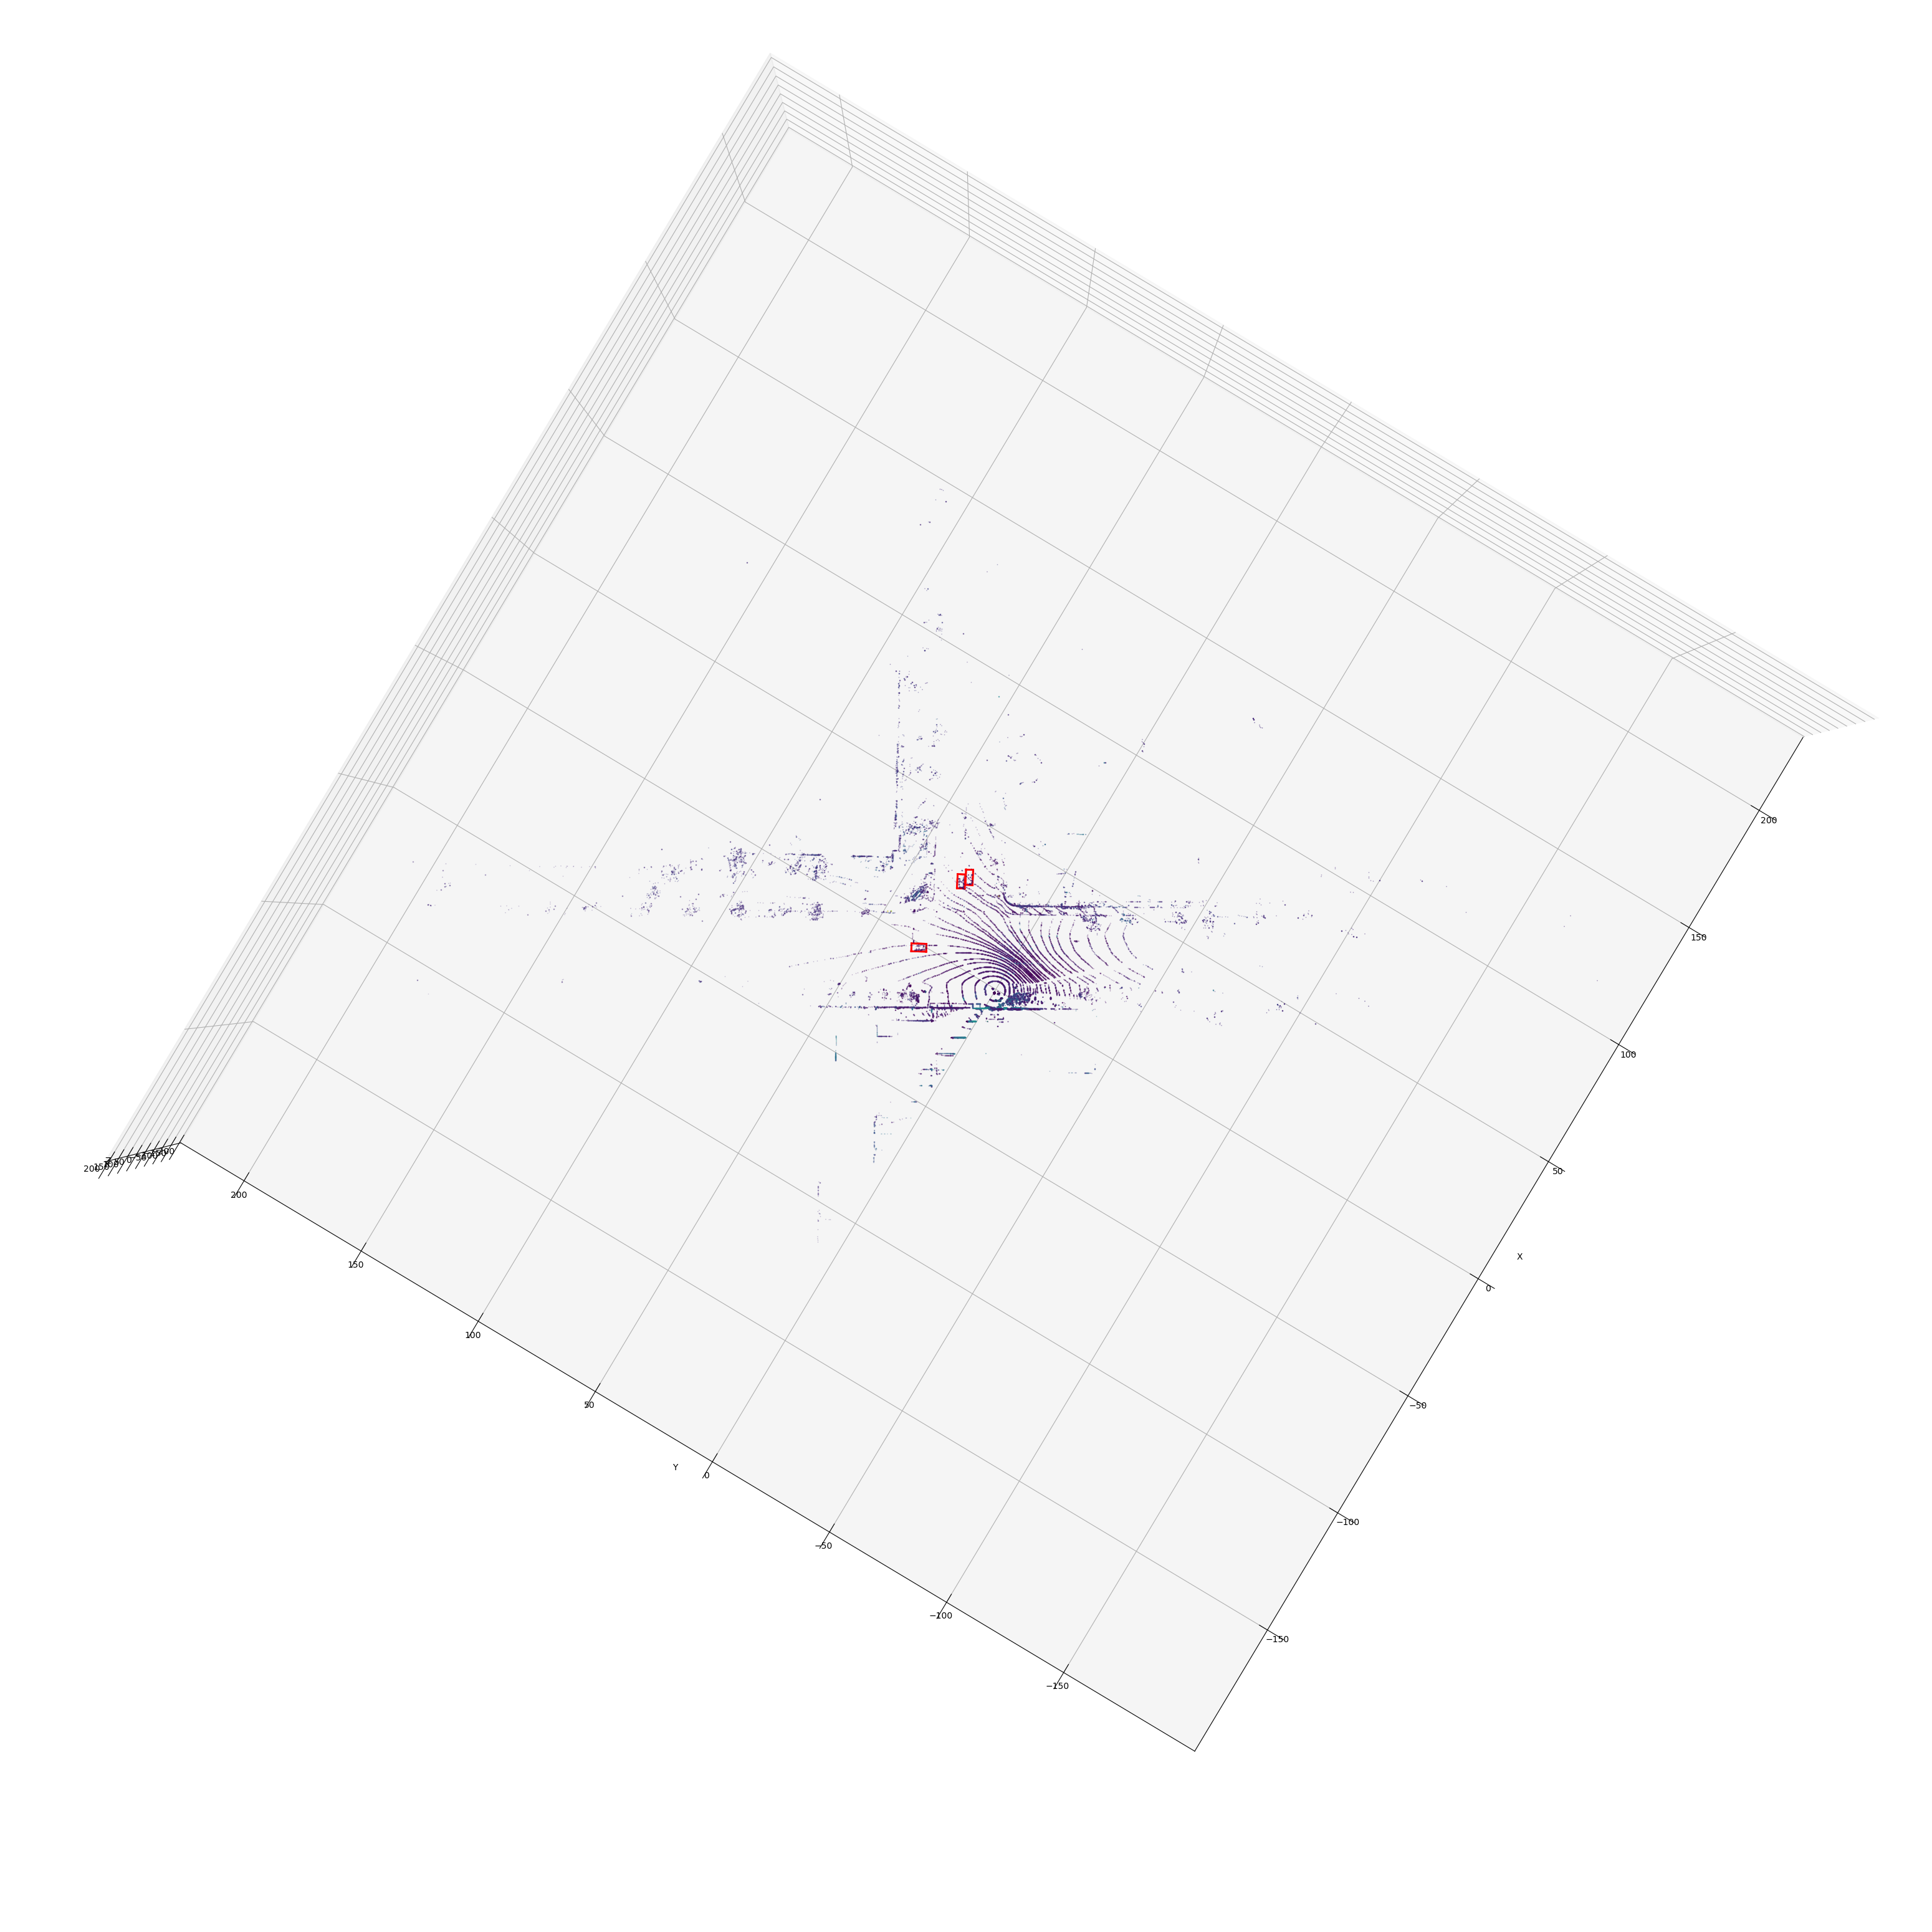

In [673]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points_0[:, 0], points_0[:, 1], points_0[:, 2], s=0.1, c=points_0[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box only if the score is above the threshold
for bbox in read_kitti_labels(labels_0):
    plot_bbox(ax, bbox)

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()


# Save the figure
fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

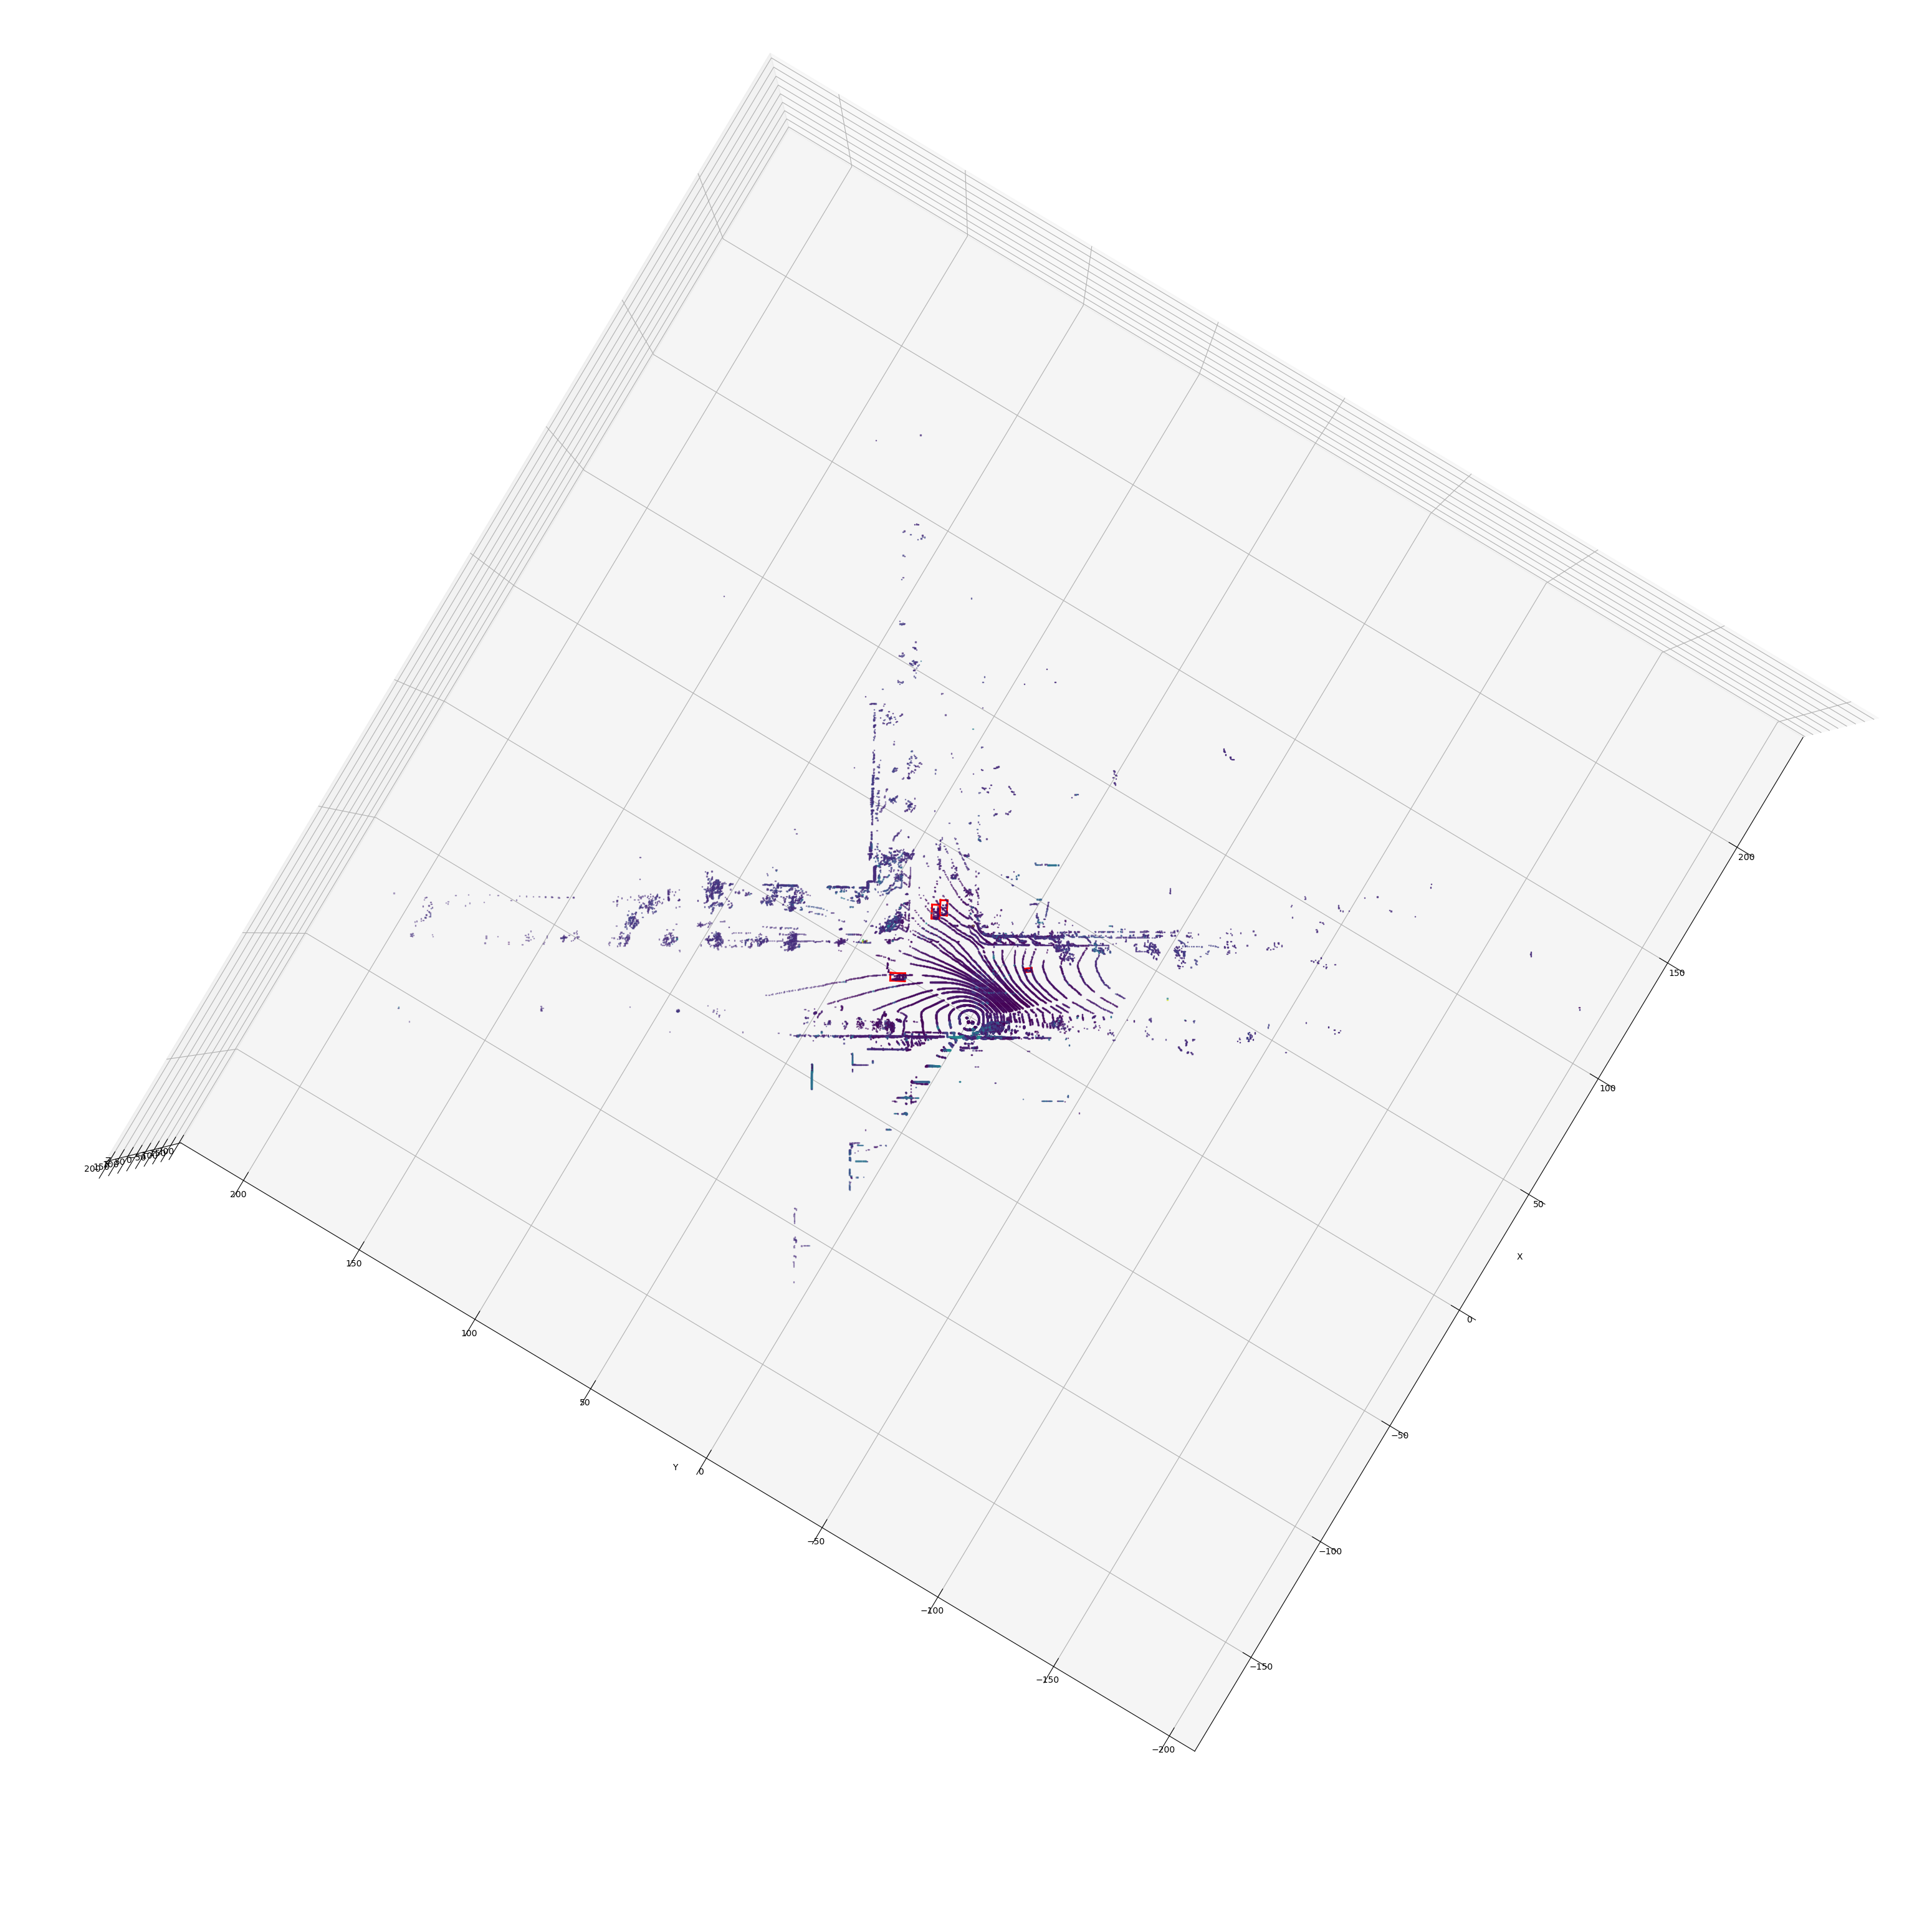

In [674]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points_1[:, 0], points_1[:, 1], points_1[:, 2], s=1, c=points_1[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box only if the score is above the threshold
for bbox in read_kitti_labels(labels_1):
    plot_bbox(ax, bbox)

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()


# Save the figure
fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

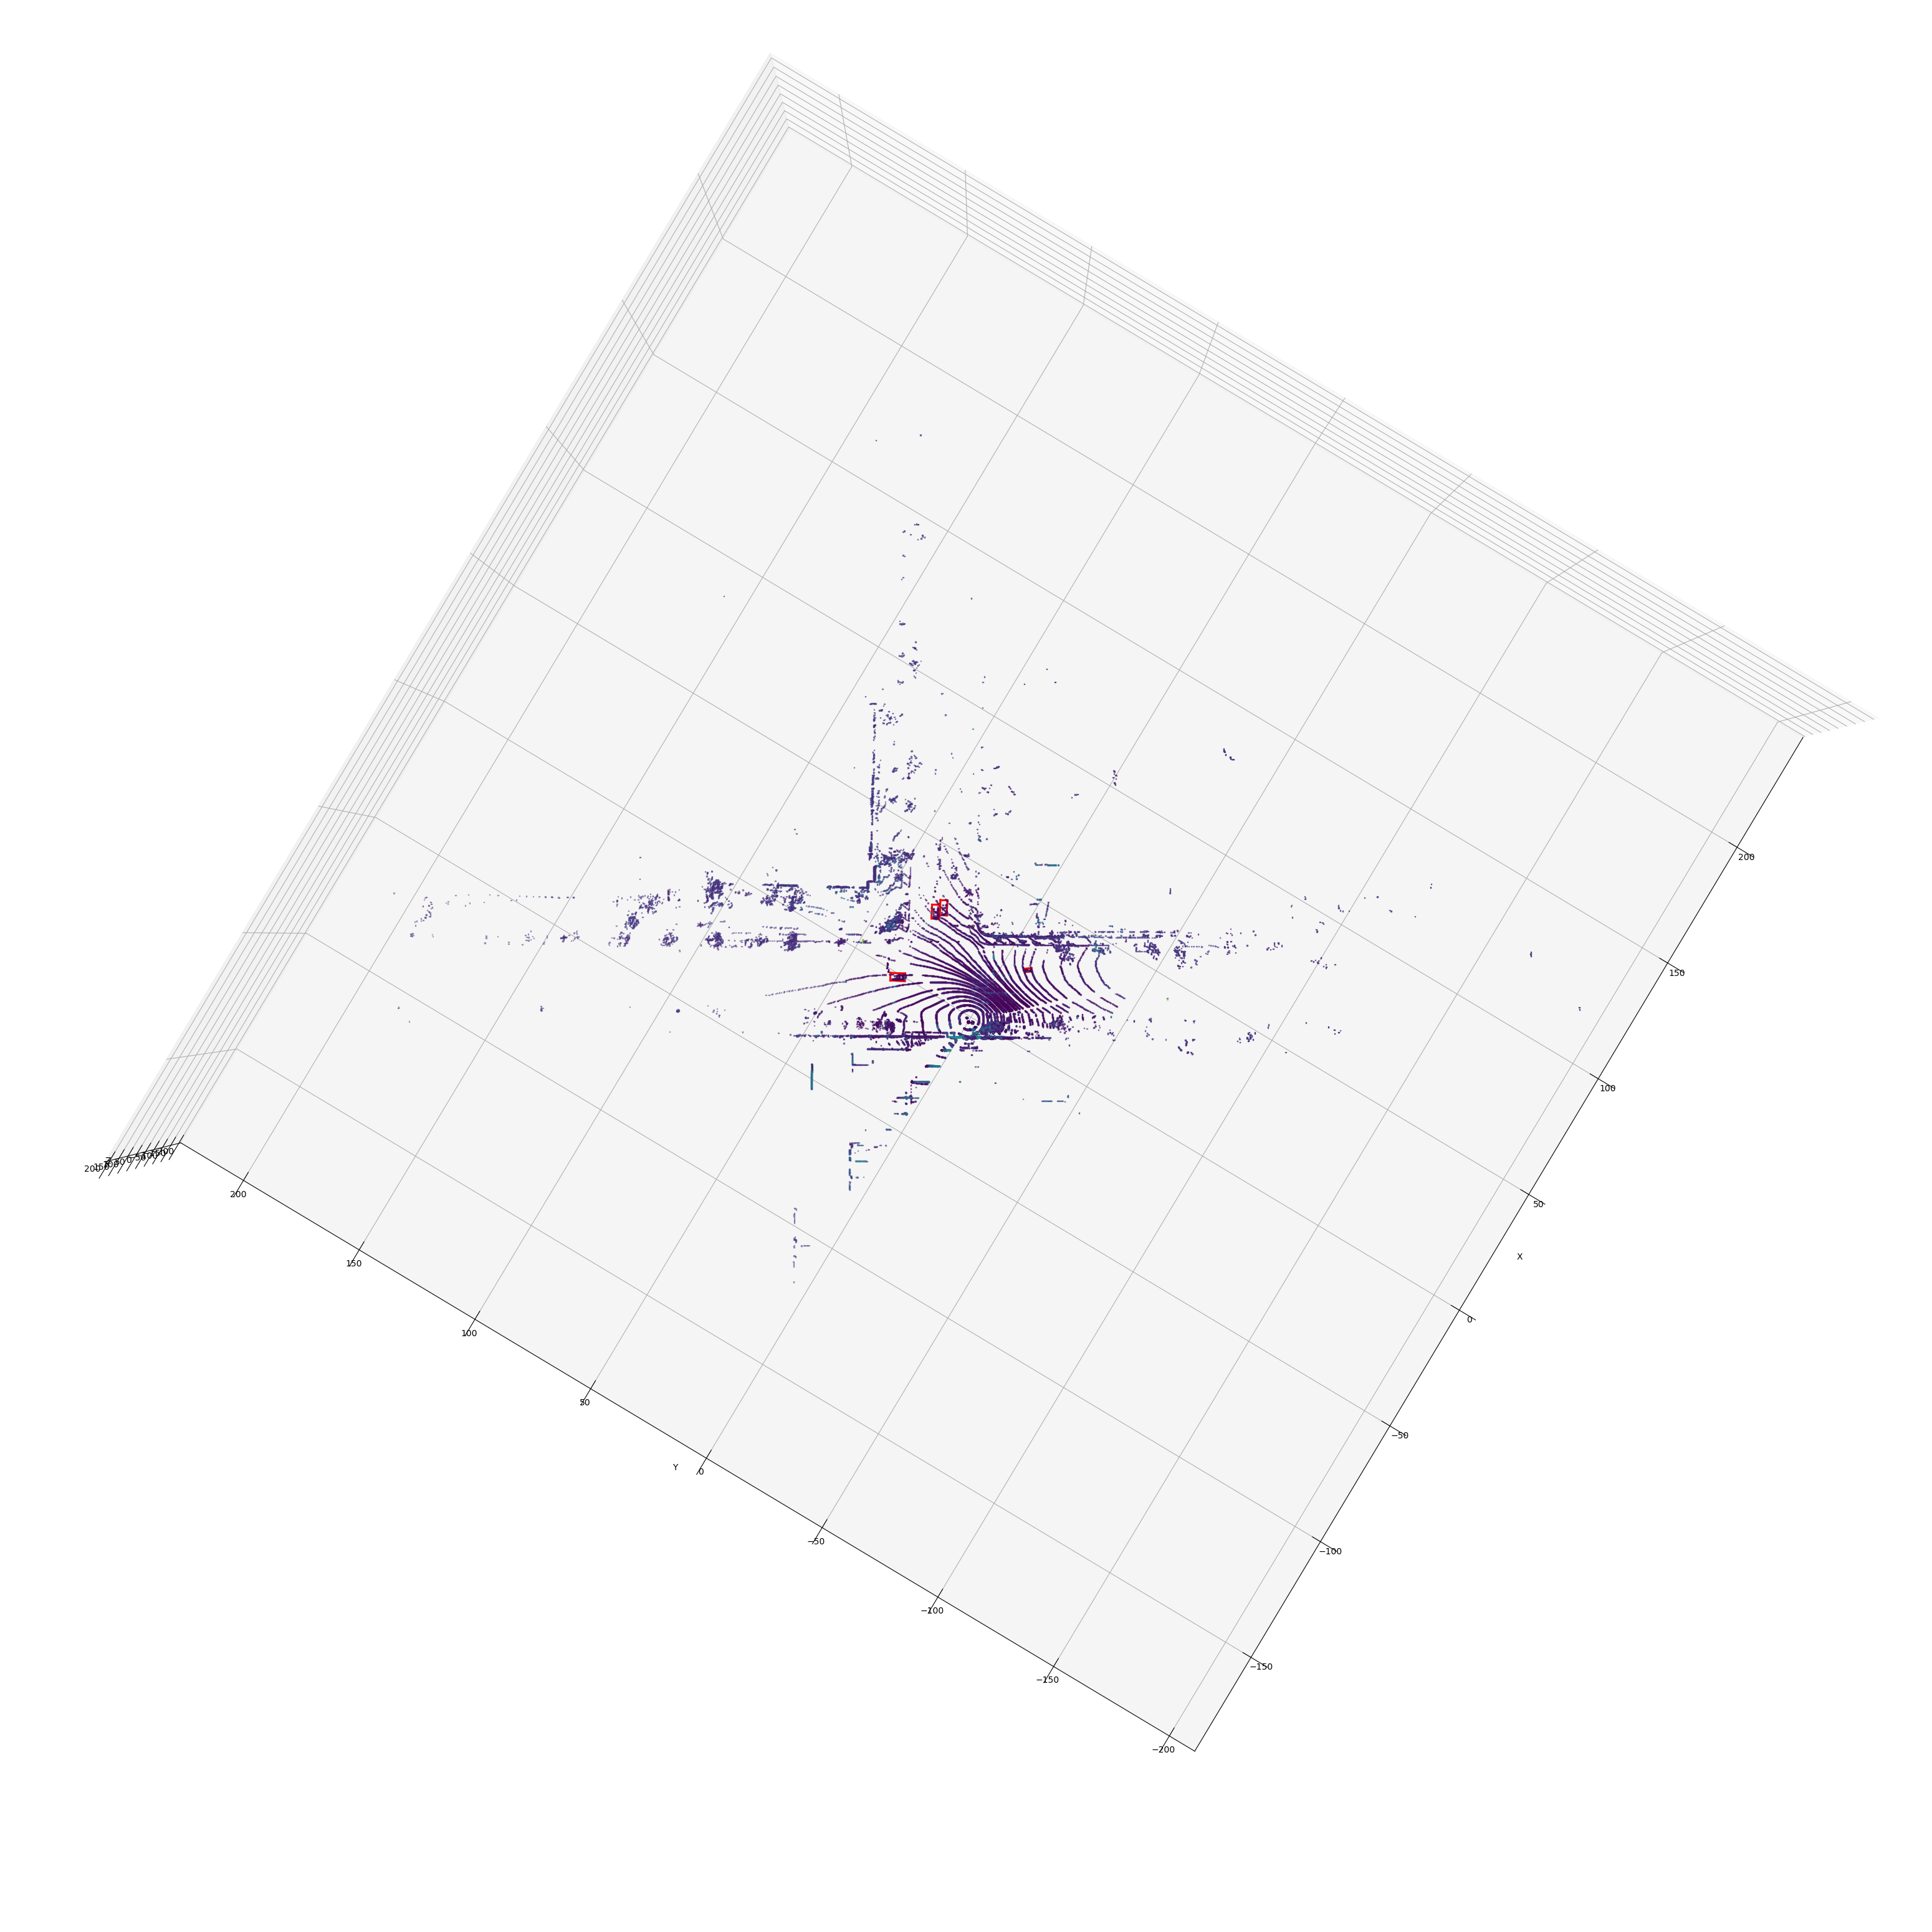

In [675]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points_2[:, 0], points_2[:, 1], points_2[:, 2], s=1, c=points_2[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box only if the score is above the threshold
for bbox in read_kitti_labels(labels_2):
    plot_bbox(ax, bbox)

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()


# Save the figure
fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

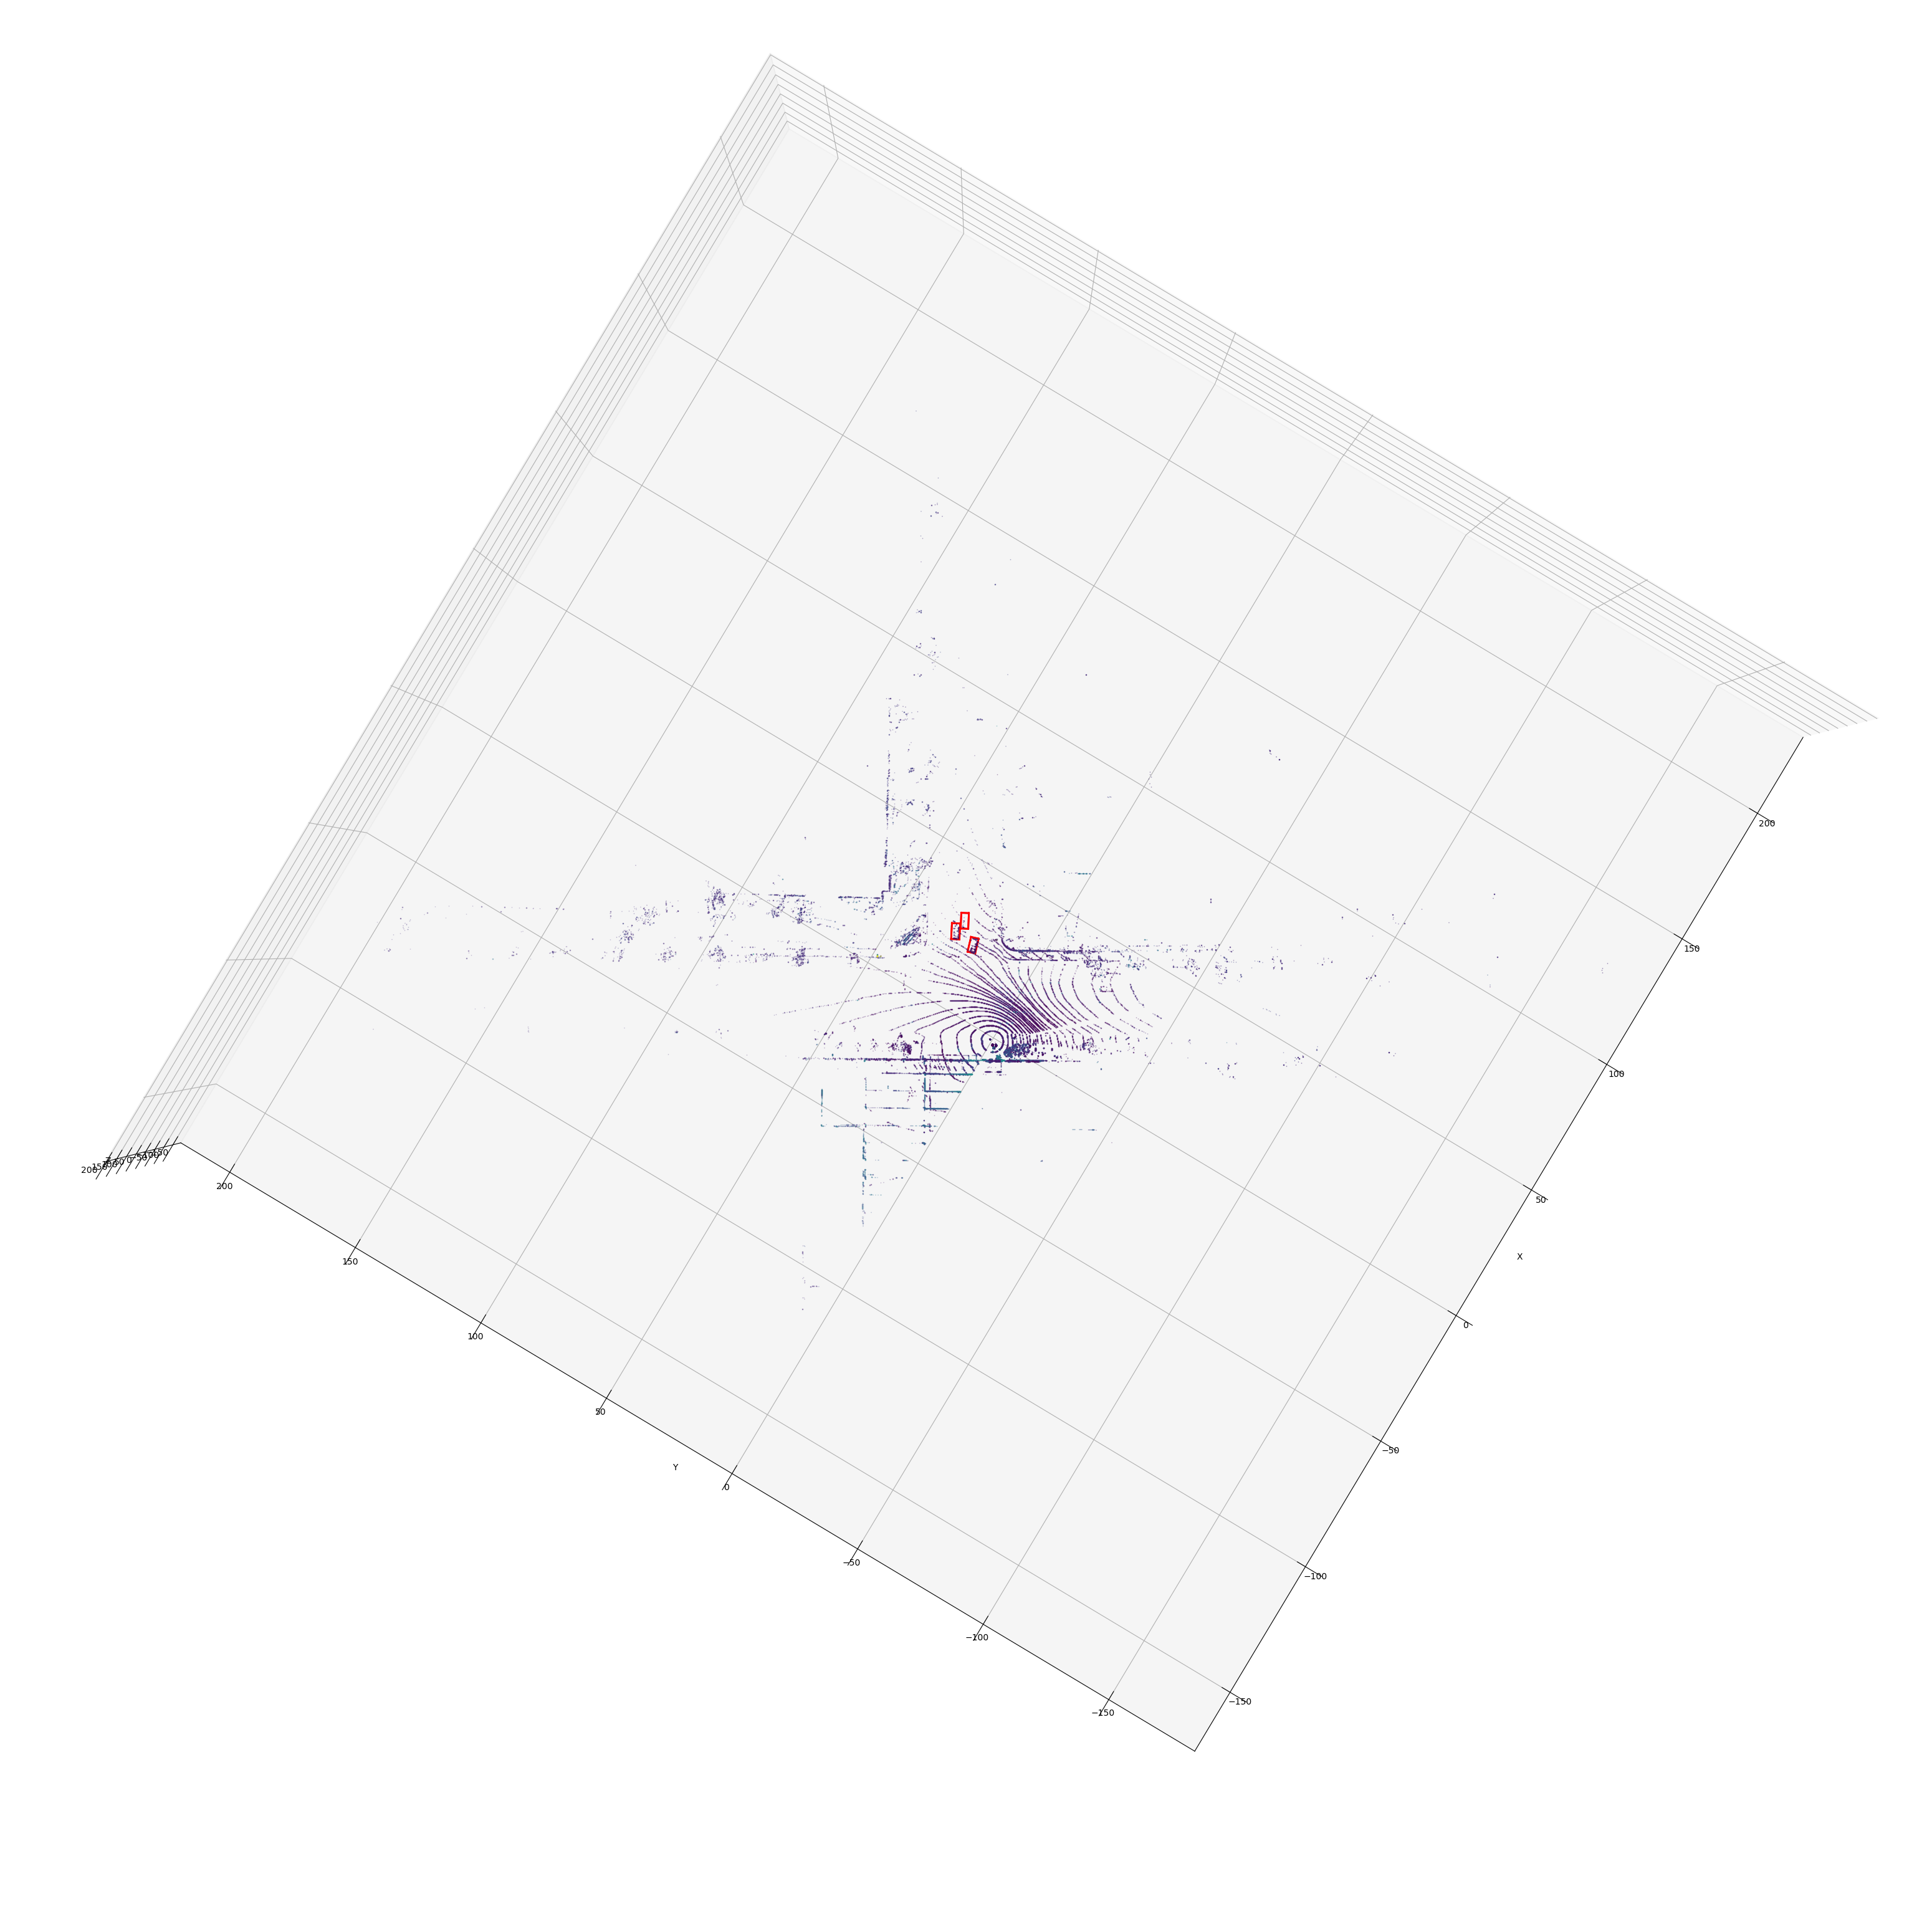

In [676]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points_3[:, 0], points_3[:, 1], points_3[:, 2], s=0.1, c=points_3[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box only if the score is above the threshold
for bbox in read_kitti_labels(labels_3):
    plot_bbox(ax, bbox)

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()


# Save the figure
fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

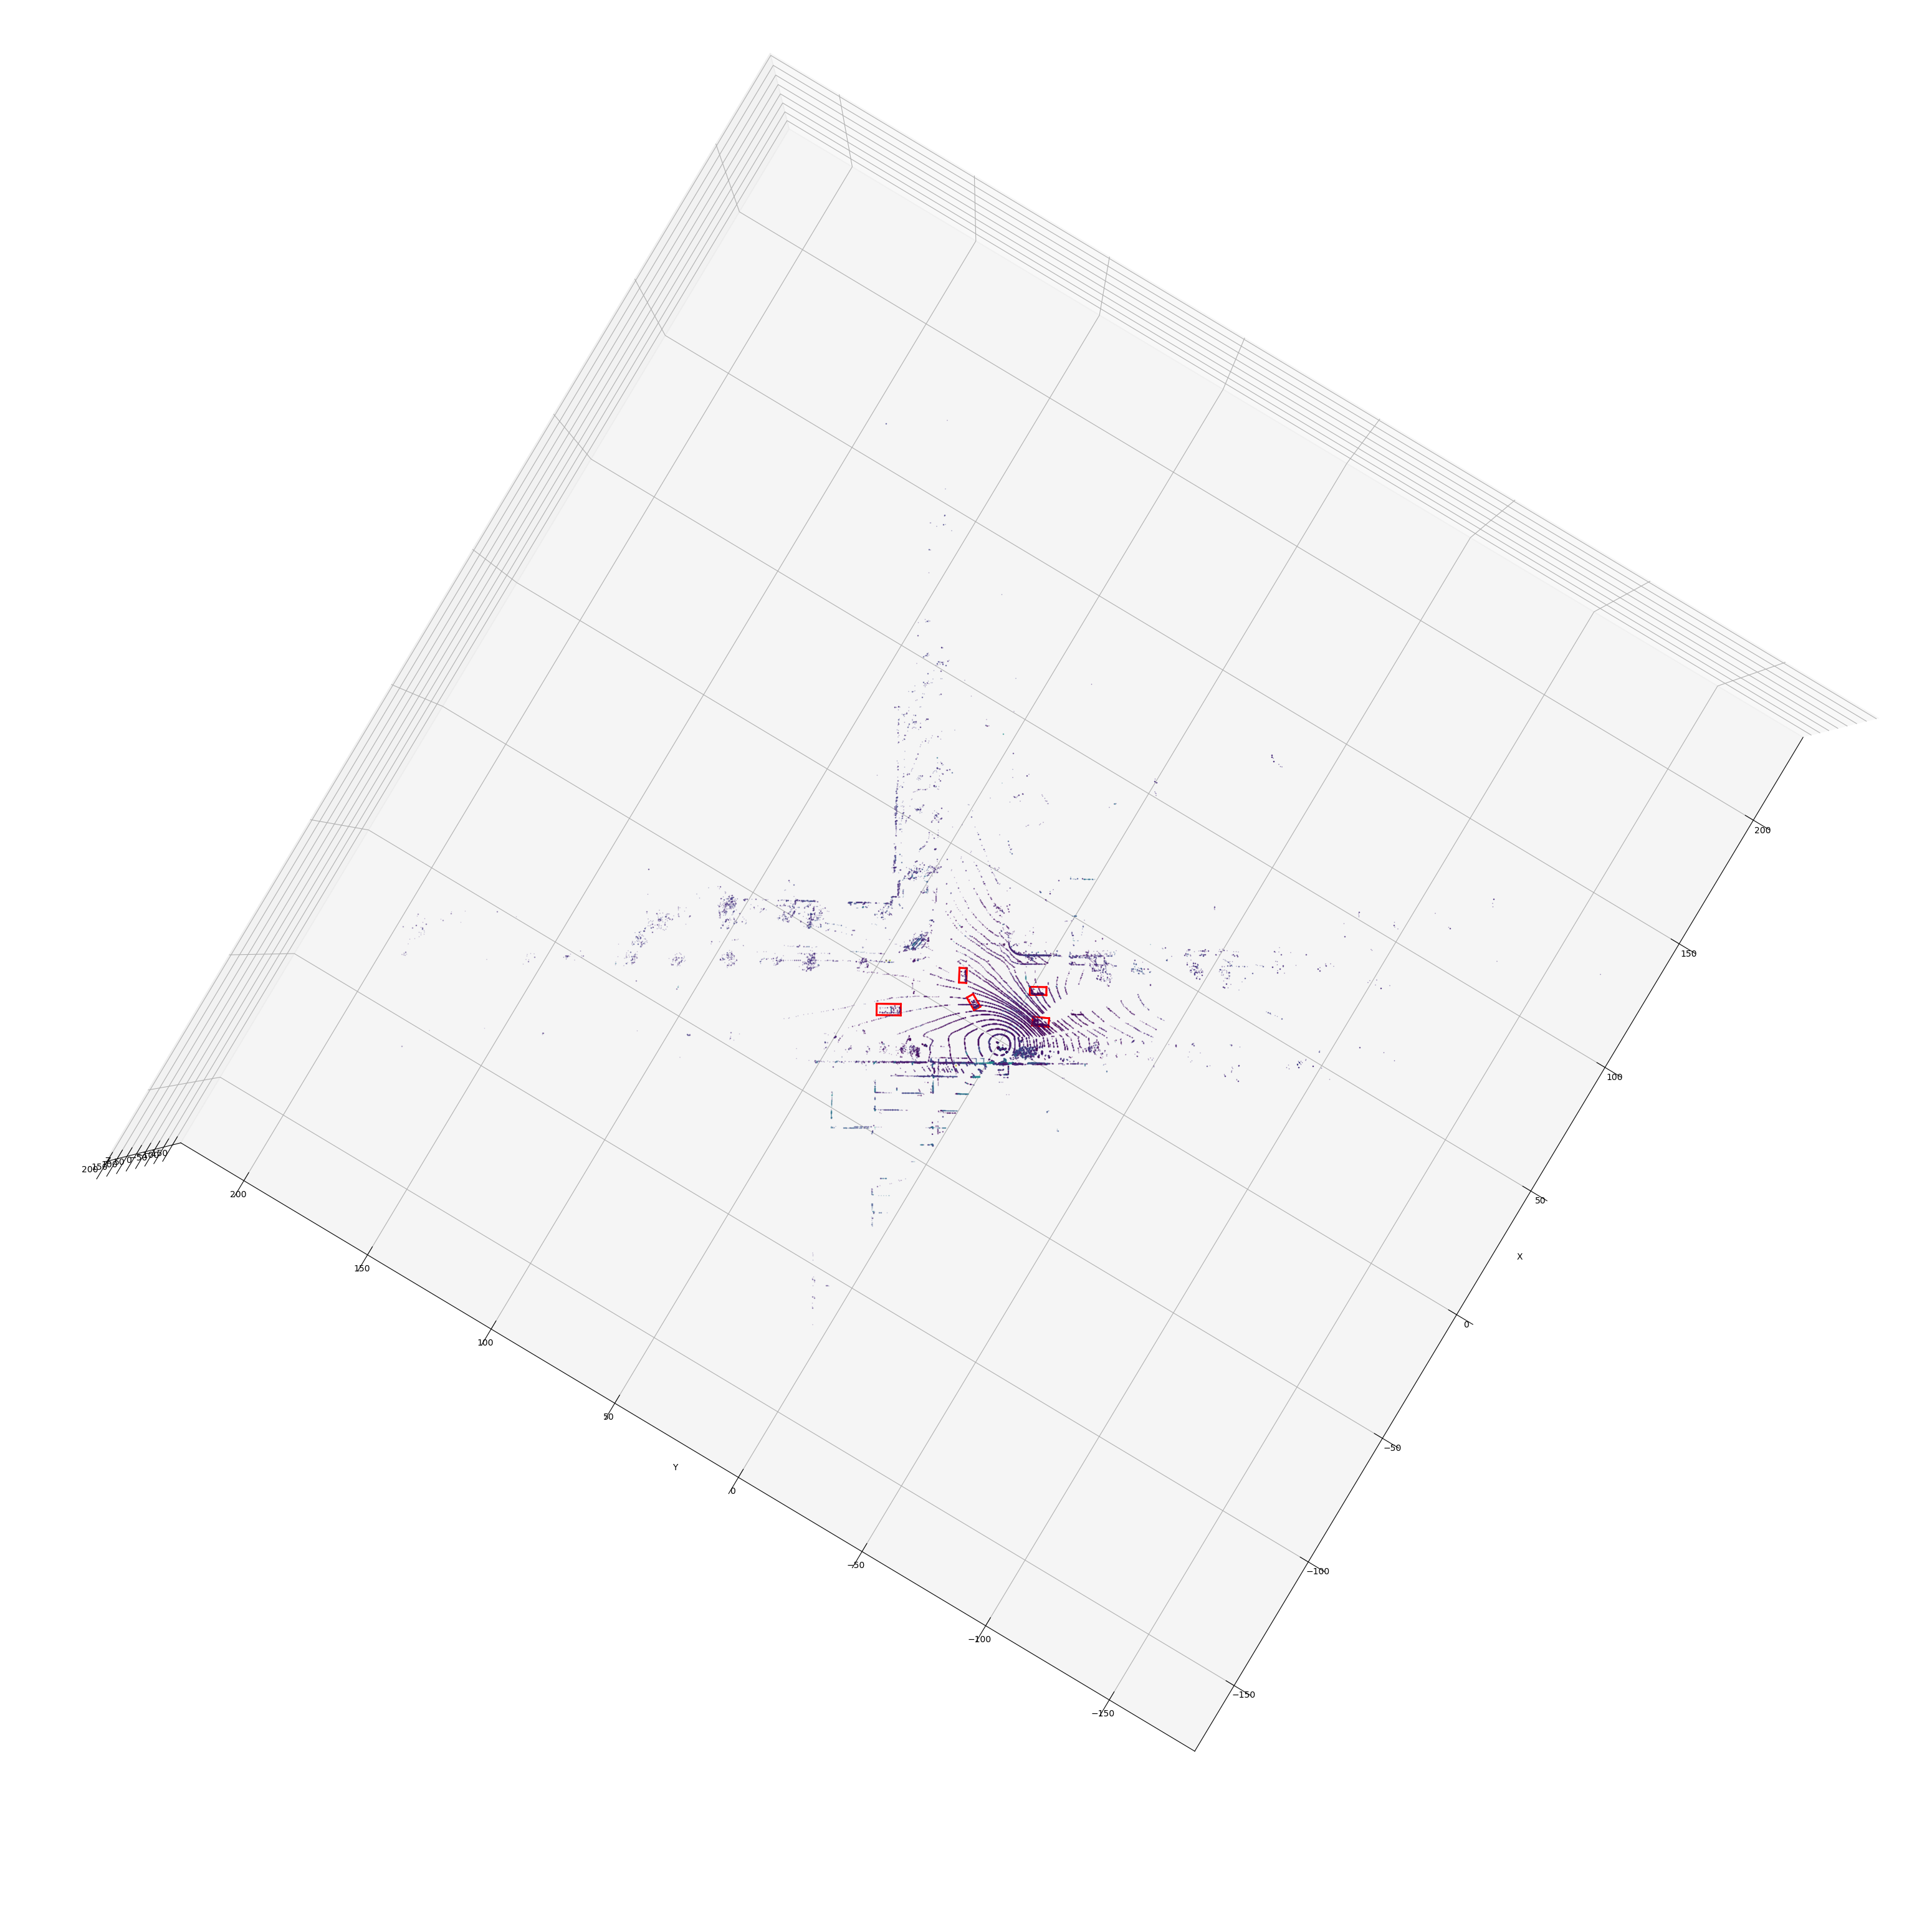

In [677]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points_4[:, 0], points_4[:, 1], points_4[:, 2], s=0.1, c=points_4[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box only if the score is above the threshold
for bbox in read_kitti_labels(labels_4):
    plot_bbox(ax, bbox)

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()


# Save the figure
fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

In [678]:
import ipywidgets as widgets
from IPython.display import display

In [679]:
# Update_plot function with a call to set_axes_equal
def update_plot(elev=30, azim=30):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.clear()

    # Plot the point cloud
    ax.scatter(points_4[:, 0], points_4[:, 1], points_4[:, 2], s=0.1, c=points_4[:, 3], cmap='viridis', marker=',')
    
    score_threshold = 0.23
    
    # Plot each bounding box only if the score is above the threshold
    for bbox in read_kitti_labels(labels_4):
        plot_bbox(ax, bbox)

    # Setting the axes properties
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Adjust the view angle
    ax.view_init(elev=elev, azim=azim)

    # Fix aspect ratio
    set_axes_equal(ax)

    plt.show()

In [680]:
# Create sliders for elevation and azimuth
elev_slider = widgets.IntSlider(min=0, max=90, step=1, value=30, description='Elevation')
azim_slider = widgets.IntSlider(min=0, max=360, step=1, value=30, description='Azimuth')

# Use interactive widgets to update the plot
widgets.interactive(update_plot, elev=elev_slider, azim=azim_slider)


interactive(children=(IntSlider(value=30, description='Elevation', max=90), IntSlider(value=30, description='A…